### Setup
The commands below are used to setup the environment. If you are working locally you can ignore them.

This notebook requires the following libraries: `pandas`, `scikit-learn`, `pystan`, `fbprophet`, `xlrd`

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Run the following to download the data
!mkdir data
!wget https://files.digital.nhs.uk/A3/625945/nhspaymentsgp-20-21-prac-csv.csv; mv *csv data/
!wget https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2021/11/Adjusted-Monthly-AE-Time-Series-October-2021.xls; mv *xls data/

This notebook requires the following libraries: `pandas`, `scikit-learn`, `pystan`, `fbprophet`, `xlrd`

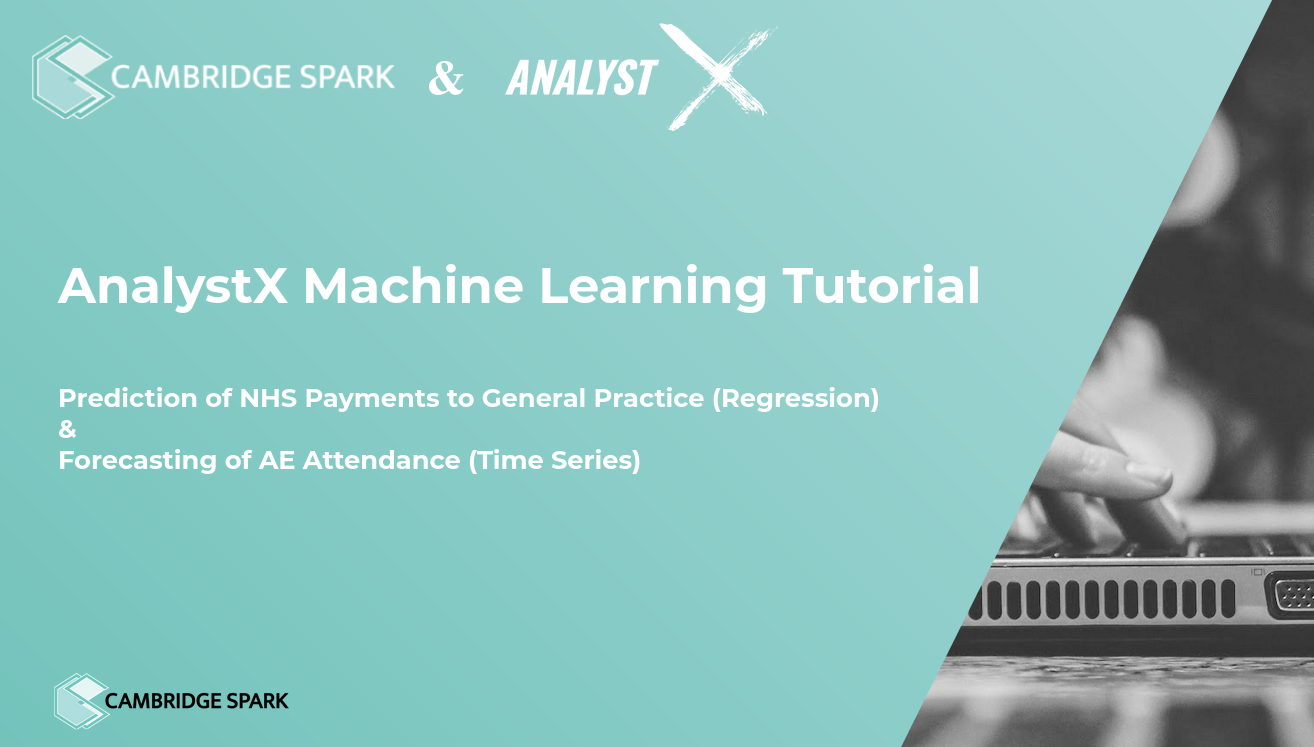

`Machine Learning`: we build a model of our data (an "approximation") that can be used to generate predictions in the future. To do so we use an algorithm that can learn relationships from the data.

Machine learning can be divided into multiple categories, depending on the algorithms and the type of data we use. Here we will cover two examples of `Supervised Learning` - one is a regression problem, the other a time-series one.

`Supervised Learning`refers to a problem where the data is labelled - we can show the algorithms examples of what we expect.

## What is regression

- Same as linear regression at school: we want to find the relationship between x and y

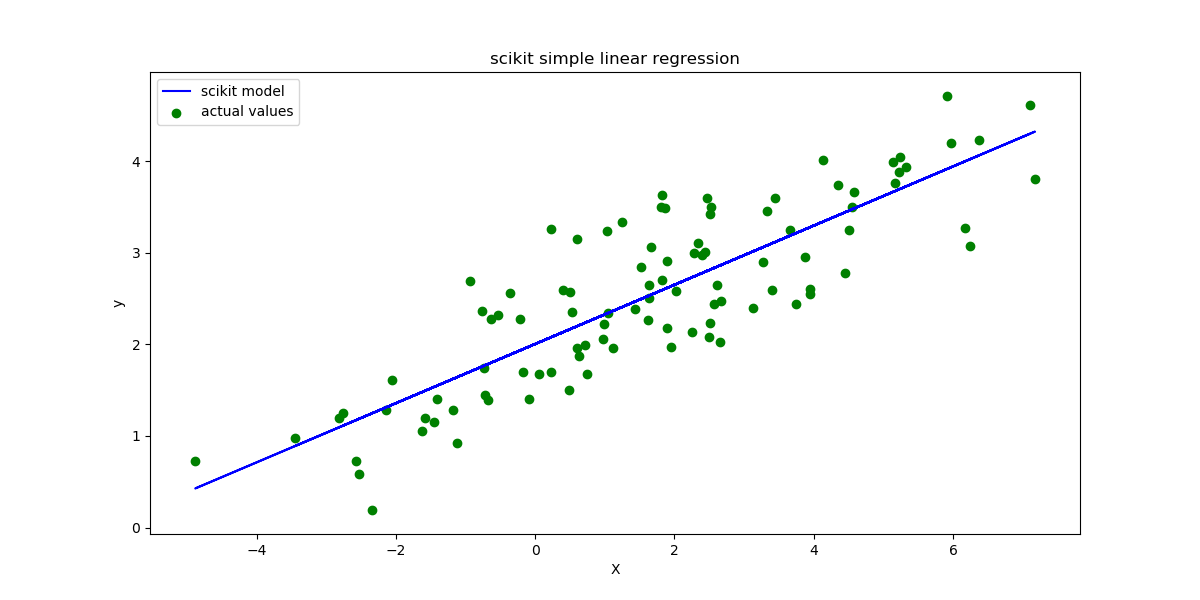

But in Machine Learning:
- x isn't just one value, it can have multiple dimensions (x1, x2, ...)
- We don't need a traight line, it can be any function
- We want to approximate the relationship between y (the outcome) and X

## How are time-series different

- Here our outcome `y` is not depending on different characteristics `x`
- Instead it only depends on past values of itself
- In other words, we want to predict future values of y based only on previous values of itself

## Example 1: Prediction of NHS Payments to General Practice (Regression)

For this example we will use the `NHS Payments to General Practice England` dataset. It contains information about general practices and how much NHS Payment they received in the year 2020-2021. Our goal will be to see if we can use characteristics of practices to predict how much payment they received.

This can be used either to predict payment for future practices (before we know it), or to analyse the relationship that links practices to the amount of payment they receive.

The dataset can be download from: https://digital.nhs.uk/data-and-information/publications/statistical/nhs-payments-to-general-practice/england-2020-21

### Loading the dataset

First we will import that `pandas` library and use it to load the dataset.

Note: we have two dates in the csv, so we add them as `parse_dates` argument to ensure they are read as dates.

In [ ]:
import pandas as pd

df = pd.read_csv("data/nhspaymentsgp-20-21-prac-csv.csv", 
                 parse_dates=["Practice Open Date", "Practice Close Date"])

Let's take a quick look at the information available:

In [ ]:
df.shape

In [ ]:
df.columns

That's a lot of columns - as we will see further we will only use a subset for our machine learning model.

### Some initial cleaning

We notice a feature called `Practice Close Date` - if a practice has closed, it is no longer relevant for our analysis, so let's get rid of those rows.

To do so we will use `pandas`'s `isnull()` to select missing value, and invert the array to select the non-missing ones.

In [ ]:
msk_closed = -df["Practice Close Date"].isnull()

df[msk_closed]

Let's remove the closed practices:

In [ ]:
df = df[-msk_closed]

We can verify those rows have been dropped:

In [ ]:
df.shape

### Features selection

Not all the columns will be useful here. In particular, a lot of the columns in this dataset are a breakdown of the payment received.

Whilst those would make predicting payment very easy (it's just the sum of all), they would not solve our problem. The breakdown is only available once we have received payment, so they are not a good predictor. 

Let's select all other columns to be our features, for the X matrix.

In [ ]:
X_columns = ['NHS England (Region) code', 'NHS England (Region) Name', 'CCG Code',
       'CCG NAME', 'PCN Code', 'PCN Name', 'Practice Code', 'Practice Name',
       'Practice Address', 'Practice Postcode', 'Practice Open Date',
       'Contract Type', 'Dispensing Practice',
       'Practice type', 'Practice Rurality', 'Atypical characteristics',
       'Number of Registered Patients (Last Known Figure)']

Great, now let's define our `X` and our `y`

In [ ]:
X = df[X_columns]
y = df["Total NHS Payments to General Practice"]

In [ ]:
X.head()

### Features Type

Our algoirithms can only work if we give them numbers. So before going further we will need to have a look at the types of our columns, and process them accordingly.

In [ ]:
X.dtypes

First we notice one numerical features, `Number of Registered Patients` - it will be easy to use as is :) Let's see what we can do for the other types.

#### Categorical features

Categorical features will be useful only if they can generalise across multiple practices. 

Those that have too many unique values wil be too specific and only describe one single practice, not enabling us to understand the general relationship between practice characteristics and payments.

Let's take a closer look at all unique values for each of those features:

In [ ]:
# We can select those columns one by one using iloc
# We can then use value_counts to know the number of unique value

for i in range(16):
    print(X.iloc[:, [i]].value_counts())
    print()

Some columns are way too specific and need to be removed, let's make a list.

Note: 
- We are removing the postcode, as it is too specific, but it would have been interesting to extract the first part only and use it as an indicator of the area.
- `Practice Open Date` has a lot of different values, because it's a date. Let's keep it for later as we can extract some information from it.

In [ ]:
to_drop = ["NHS England (Region) code", "CCG Code", "CCG NAME", 
           "PCN Code", "PCN Name", "Practice Code", "Practice Name", 
           "Practice Address", "Practice Postcode", "Atypical characteristics", 
           "Dispensing Practice"]

Let's drop them!

In [ ]:
X.drop(to_drop, axis=1, inplace=True)
X.dtypes

Now let's deal with the remaining categorical features!

In [ ]:
cat_cols = ["NHS England (Region) Name", "Contract Type", "Practice type", "Practice Rurality" ]

X[cat_cols].head()

Those categorical columns need to be converted to numbers. 

`pd.get_dummies()` can be used to generate 0s and 1s representing every possible value for each feature. Let's convert them!

Note: this technique is called `One-Hot Encoding`, you can read more about it [here](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/)

In [ ]:
X_cat = pd.get_dummies(X[cat_cols])

X_cat.head()

Now let's merge the numerical version of our categorical feature into the original X. We will also drop the old categorical columns, as they are no longer needed.

In [ ]:
X = pd.concat([X, X_cat], axis=1)
X.drop(cat_cols, axis=1, inplace=True)

X.head()

Great, we're almost done! The only non-numerical feature now is the `Practice Open Date`.

#### Dealing with dates (feature engineering)

Unfortunately algorithms aren't able to do anything with a date alone, it needs a number.

So we need to be creative in how to use this date, here we will use it to generate a new column `Number of Days since Opened`. 

In Machine Learning jargon, this stage is usually refered to as Features Engineering (building new features by transforming existing ones)

In [ ]:
X["Number of Days since Opened"] = (pd.Timestamp.now() - X["Practice Open Date"]).dt.days

We can now drop the old Practice Open Date

In [ ]:
X.drop("Practice Open Date", axis=1, inplace=True)

Great, all our features our numerical now!

In [ ]:
X.dtypes

In [ ]:
X.head()

### Let's train our model!

There are many machine learning algorithms one could use to solve this regression problem. The Python library `scikit-learn` implements a lot of them to make it easy for a Data Scientist to just import them. They also provide a great documentation.

You can find all supervised learning algorithms [here](https://scikit-learn.org/stable/supervised_learning.html)

`scikit-learn` also provides tools to prepare our data for Machine Learning - the `train_test_split` function for instance allows us to split our dataset into a `training set` and a `test set`, so we can use one to learn from, and the other to test the performance of our model. Let's use it:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [ ]:
# Our training set
X_train.head()

In [ ]:
# Our test set
X_test.head()

For the purpose of this tutorial, we decided to use a simple algorithm called `Decision Tree`, which will build a tree with binary rules for us.

You can read more about the algorithm [here](https://scikit-learn.org/stable/modules/tree.html)

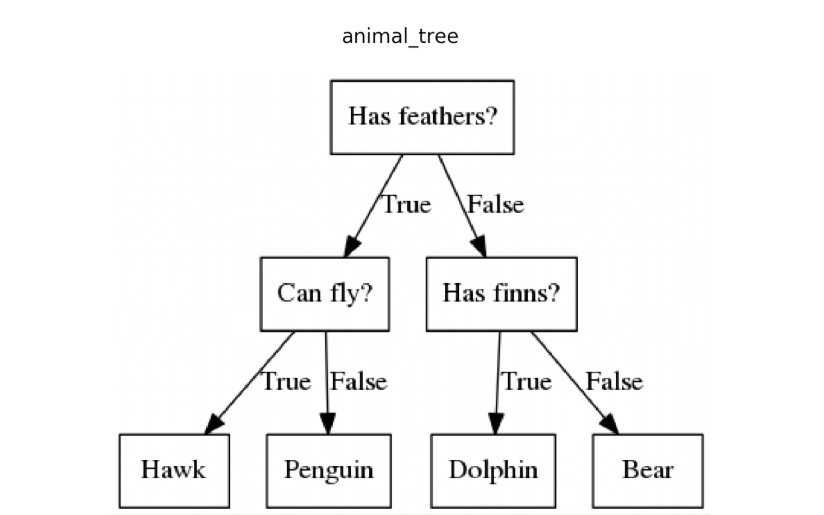

Let's import the `DecisionTreeRegressor` (a decision tree for regression problems) and instantiate it with the default parameters:

In [ ]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(random_state=42)

To train our model, we use the `.fit` method and give it our training set X and y:

In [ ]:
model.fit(X_train, y_train)

That's it, now we have a trained model that can be used to generate predictions.

If we use the `predict` method we can generate predictions for any practice in our test dataset. Let's try with a row at random:

In [ ]:
idx = 10

practice = X_test.iloc[[idx]]
practice

In [ ]:
actual = y_test.iloc[idx]
print("Actual payment: {}".format(actual))

In [ ]:
# Generate prediction
prediction = model.predict(practice)[0]

print("Prediction: {}".format(prediction))
print("Difference: {}".format(100*abs(actual-prediction)/actual))

This is for just one value, but we can use predict to generate predictions for all the rows in `X_test`:

In [ ]:
y_pred = model.predict(X_test)

`scikit-learn` also provides functions to compute useful metrics. Those can be use to evaluate how good our model is on the test set. 

Here we will compute the [`Mean absolute error`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html), which tells us, on average, by how much our model is wrong. We can also express it as a percentage to make it easier to estimate how good/bad we are doing.

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [ ]:
mean_absolute_error(y_test, y_pred)

In [ ]:
mean_absolute_percentage_error(y_test, y_pred)

On average, our model is wrong by ~300k (or about ~30%) - this seems pretty bad...

This is likely due to the fact we just used an algorithm out of the box without tuning it. 

Most algorithms take parameters as input that allow to constrain the way it learns and avoid [overfitting/underfitting](https://towardsdatascience.com/overfitting-vs-underfitting-a-complete-example-d05dd7e19765).

For Decision Trees, the main parameters are:
- `max_depth`: the maximal size of our tree. The deepest the most likely it will overfit. Here let's try a short tree with only 86 layers
- `min_sample_split`: the minimal amount of examples to justify creating a new node in our tree. Higher values ensure we do not create binary rules (nodes) for only one example. Let's set it to 10.

In [ ]:
model = DecisionTreeRegressor(max_depth=6, min_samples_split=10, random_state=42)

We can now train our model again and see how the error has improved:

In [ ]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mean_absolute_percentage_error(y_pred, y_test)

That's a bit better - but far from perfect. There are multiple ways you can try to improve this:
- Spend more time finding the best parameters for the `DecisionTreeRegressor`. To do so you can use methods such as [GridSearch](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold)
- Build more features using features engineering, analyse predictions to see if our model does better/worse for certain practices and spend more time cleaning the data
- Add more data by our dataset to other datasets providing more information about practices
- Use a different [algorithm](https://scikit-learn.org/stable/supervised_learning.html)

Finally, we can visualise our tree:

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig= plt.figure(figsize=(50, 10))
plot_tree(model, max_depth=3, fontsize=10, impurity=False, ax=fig.gca(), feature_names=X.columns)

We can also look at the feature importance:

In [ ]:
pd.DataFrame(model.feature_importances_, index=X.columns, 
             columns=["importance"]).sort_values("importance", ascending=False)

# Example 2: Forecasting of AE Attendance (Time Series)

In this example we will use a time-series algorithm to forecast the AE attendance for a whole year. 

Time-series algorithms are able to extract trend, seasonality and other signal from past data, in order to generate a forecast.

You can download the dataset [here](https://www.england.nhs.uk/statistics/statistical-work-areas/ae-waiting-times-and-activity/)

First let's load the data with pandas:

In [ ]:
df = pd.read_excel("data/Adjusted-Monthly-AE-Time-Series-October-2021.xls", skiprows=17, parse_dates=["Period"])

Here we want to have the date as index, and a column `y` for the value we are trying to predict.

In [ ]:
df.set_index("Period", inplace=True)

In [ ]:
y = df[["Total Attendances"]]

In [ ]:
y.plot(figsize=(20, 10))

We can see a big drop in regular attendances in 2020. This is not something our model, which learns about past data only, could have predicted. So for the purpose of this tutorial, we will use:
- Data up to 2018 for training
- Data in 2019 for testing

In [ ]:
# Remove data after 2020
y = y[y.index < "2020-01-01"]

# Select y_train and y_test
y_train = y[y.index < "2019-01-01"]
y_test = y[(y.index >= "2019-01-01")]

In [ ]:
y_train.plot()

In [ ]:
y_test.plot()

Unfortunately time-series are not supported by sklearn, but there exists multiple libraries such as `statsmodels` (which implements ARIMA models) and `keras` (for a Neural Networks approach to time series).

In this tutorial, we will use the [Prophet](https://facebook.github.io/prophet/) library from Facebook to generate forecasts.


In [ ]:
from prophet import Prophet

To use prophet we need to modify our dataset so it looks like: 
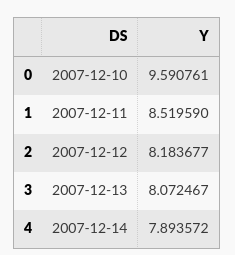

In [ ]:
y_train_prophet = y_train.reset_index().rename({"Period": "ds", "Total Attendances": "y"}, axis=1)
y_train_prophet.head()

In [ ]:
y_test_prophet = y_test.reset_index().rename({"Period": "ds", "Total Attendances": "y"}, axis=1)
y_test_prophet

In [ ]:
m = Prophet()
m.fit(y_train_prophet)

Generate predictions

In [ ]:
predictions = m.predict(y_test_prophet[["ds"]])

In [ ]:
predictions

In [ ]:
m.plot(predictions)

In [ ]:
m.plot_components(predictions)

Let's put all in one dataframe for anaylise

In [ ]:
result = pd.concat([y_train_prophet, y_test_prophet]).set_index("ds")
result["y_pred"] = predictions.set_index("ds")["yhat"]

result

In [ ]:
result[24:].plot(figsize=(20, 10))

we can use sklearn to compute the mean absolute error:

In [ ]:
mean_absolute_error(predictions["yhat"], y_test_prophet["y"])

In [ ]:
mean_absolute_percentage_error(predictions["yhat"], y_test_prophet["y"])

We can improve this result by:
- Tuning the model better. We can add holidays, additional seasonality and [more](https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html). 
- Use [Time series cross validation](https://towardsdatascience.com/time-series-nested-cross-validation-76adba623eb9) to tune and estimate performance
- Use different models such as ARIMA (from `statsmodels`) or neural networks as RNN/LSTM (using `keras)
- Add more data - either more years of the same data or features that correlate with our output and can help predicting it (weather data, etc..)